In [4]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

Let's explore a bit the dataset

In [ ]:
mvp_2022 = pd.read_csv("../Data/Raw/MVP2022.csv", header = 1)
mvp_2022.head()

Now we will create some code to clean all the datasets, save them individually, and also concatenate them in one to save it as well

First we create two empty lists to store keys and values, and an empty dictionary where we will link the previous lists.

Then we do a for loop to create key names and extract the datasets.

In [134]:
df_name = []
df_data = []

for x in range(23):
    df_name.append("mvp_"+str(2000+x))
    df_data.append(pd.read_csv("../Data/Raw/MVP{}.csv".format(2000+x), header = 1))

Now we link the keys yo the values, and also do another for loop to clean the data:

- Drop a useless column
- Create columns with PTS, AST, TRB, STL and BLK per minute, in order to not give the edge to players with higher minutes per game.
- A column with all stats combined per minute.
- Create another column with the year of the MVP to differentiate it with the others once we concatenate them all.
- Clean some values from the Rank column.
- Fill in some missing values.

In [135]:
mvps = dict(zip(df_name, df_data))
    
for key, x in zip(mvps, range(23)):
    mvps[key] = mvps[key].drop(columns = mvps[key].columns[-1])
    mvps[key]["PTS/M"] = mvps[key]["PTS"]/mvps[key]["MP"]
    mvps[key]["TRB/M"] = mvps[key]["TRB"]/mvps[key]["MP"]
    mvps[key]["AST/M"] = mvps[key]["AST"]/mvps[key]["MP"]
    mvps[key]["STL/M"] = mvps[key]["STL"]/mvps[key]["MP"]
    mvps[key]["BLK/M"] = mvps[key]["BLK"]/mvps[key]["MP"]
    mvps[key]["Stats/M"] = mvps[key]["PTS/M"]+mvps[key]["TRB/M"]+mvps[key]["AST/M"]+mvps[key]["STL/M"]+mvps[key]["BLK/M"]
    mvps[key]["Year"] = (2000+x)
    mvps[key] = mvps[key].fillna(0)
    mvps[key]["Rank"] = mvps[key]["Rank"].replace("T",'',regex=True).astype(int)
    mvps[key].to_csv("../Data/Cleaned/CleanMVP{}.csv".format(2000+x), index = False)

Now we concatenate all.

In [136]:
data = pd.concat(mvps.values(), ignore_index = True)
data.shape

(326, 27)

In [ ]:
data.head()

And save the dataset.

In [ ]:
data.to_csv("../Data/Cleaned/CleanMVPs.csv", index = False)

Now we are going to split the dataset into two, one to predict Rank and another to predict Share, we are going to also drop Player, Tm, First, Pts Won, Pts Max and Year, as this are columns that are either not useful or directly correlated to the MVP.

In [140]:
data_rank = data.drop(columns = ["Player", "Tm", "Share", "First", "Pts Won", "Pts Max", "Year"])
data_share = data.drop(columns = ["Player", "Tm", "Rank", "First", "Pts Won", "Pts Max", "Year"])

Now we define a function to get rid of all the columns that don't reach a threshold of correlation with our target column.

In [141]:
def correlation(df, target = -1, threshold=0.75):
    '''Checks for correlation between a target column and the rest,
    drops columns that are below the threshold.
    
    Parameters: dataframe, target (column index, default = -1), threshold (default = 0.75)
    Returns: dataframe with columns above the threshold, displays Seaborn Heatmap'''
    
    df2 = df.copy()
    corr_matrix = df2.corr().abs()
    for i in range(len(corr_matrix.columns)):
        if (corr_matrix.iloc[i,target] < threshold):
            df2 = df2.drop(columns = corr_matrix.columns[i])
    display(sns.heatmap(df2.corr(), annot=True))
    return df2

<AxesSubplot:>

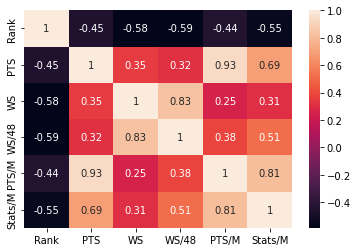

In [142]:
data_rank = correlation(data_rank,0,0.4)

In [ ]:
data_share = correlation(data_share,1,0.4)

Well, we are left with very few columns, and the ones we have are highly related to each other in some cases: WS with WS/48, PTS and PTS/M, and PTS/M with Stats/M, which was expected.

We are going to drop WS in both datasets, as well as PTS and PTS/M for the Rank dataset based on multicollinearity.

In [ ]:
data_rank = data_rank.drop(columns = ["WS", "PTS", "PTS/M"])
data_share = data_share.drop(columns = "WS")

Now we can do our X/y splits

In [ ]:
rank_X = data_rank.drop(columns = "Rank")
rank_y = data_rank["Rank"]
share_X = data_share.drop(columns = "Share")
share_y = data_share["Share"]

And the Train/Test splits

In [ ]:
rank_X_train, rank_X_test, rank_y_train, rank_y_test = train_test_split(rank_X, rank_y, test_size = 0.22, random_state = 22)
share_X_train, share_X_test, share_y_train, share_y_test = train_test_split(share_X, share_y, test_size = 0.22, random_state = 22)

In [76]:
def hist_maker(df):
    '''Returns histplots in a single fig for each column of a given DataFrame
    
    Input: DataFrame
    Output: Histplots of all the columns'''
    
    cols = list(df.columns)
    x = len(cols)
    fig, ax = plt.subplots(1,x, figsize=(20,10))

    for col in cols:
        y = cols.index(col)
        sns.histplot(data=df, x=col, ax = ax[y])
        ax[y].set_title(col)
        
    return

In [ ]:
hist_maker(share_X_train)

Let's apply a logarithmic transformation to the Stats/M columns to make it closer to  a normal distribution.

In [ ]:
rank_pt = PowerTransformer().fit(rank_X_train)

with open("../Transformers/rank_pt.pkl", "wb") as file:
    pickle.dump(rank_pt, file)

rank_X_train_pt = rank_pt.transform(rank_X_train)
rank_X_train_pt = pd.DataFrame(rank_X_train_pt, columns = rank_X_train.columns, index = rank_X_train.index)

rank_X_test_pt = rank_pt.transform(rank_X_test)
rank_X_test_pt = pd.DataFrame(rank_X_test_pt, columns = rank_X_test.columns, index = rank_X_test.index)


share_pt = PowerTransformer().fit(share_X_train)

with open("../Transformers/share_pt.pkl", "wb") as file:
    pickle.dump(share_pt, file)

share_X_train_pt = share_pt.transform(share_X_train)
share_X_train_pt = pd.DataFrame(share_X_train_pt, columns = share_X_train.columns, index = share_X_train.index)

share_X_test_pt = share_pt.transform(share_X_test)
share_X_test_pt = pd.DataFrame(share_X_test_pt, columns = share_X_test.columns, index = share_X_test.index)

In [ ]:
hist_maker(rank_X_train)

Now we scale everythin with a MinMaxScaler.

In [ ]:
rank_scaler = MinMaxScaler().fit(rank_X_train_pt)

with open("../Scalers/rank_scaler.pkl", "wb") as file:
    pickle.dump(rank_scaler, file)

rank_X_train_pt_mm = rank_scaler.transform(rank_X_train_pt)
rank_X_train_pt_mm = pd.DataFrame(rank_X_train_pt_mm, columns = rank_X_train_pt.columns, index = rank_X_train_pt.index)

rank_X_test_pt_mm = rank_scaler.transform(rank_X_test_pt)
rank_X_test_pt_mm = pd.DataFrame(rank_X_test_pt_mm, columns = rank_X_test_pt.columns, index = rank_X_test_pt.index)


share_scaler = MinMaxScaler().fit(share_X_train_pt)

with open("../Scalers/share_scaler.pkl", "wb") as file:
    pickle.dump(share_scaler, file)

share_X_train_pt_mm = share_scaler.transform(share_X_train_pt)
share_X_train_pt_mm = pd.DataFrame(share_X_train_pt_mm, columns = share_X_train_pt.columns, index = share_X_train_pt.index)

share_X_test_pt_mm = share_scaler.transform(share_X_test_pt)
share_X_test_pt_mm = pd.DataFrame(share_X_test_pt_mm, columns = share_X_test_pt.columns, index = share_X_test_pt.index)

In [ ]:
rank_lr = LinearRegression().fit(rank_X_train_pt_mm, rank_y_train)

with open("../Models/rank_lr.pkl","wb") as file:
    pickle.dump(rank_lr, file)

rank_train_y_pred = rank_lr.predict(rank_X_train_pt_mm)
rank_test_y_pred = rank_lr.predict(rank_X_test_pt_mm)
 
print(round(r2_score(rank_y_train, rank_train_y_pred),2))
print(round(r2_score(rank_y_test, rank_test_y_pred),2))


share_lr = LinearRegression().fit(share_X_train_pt_mm, share_y_train)

with open("../Models/share_lr.pkl", "wb") as file:
    pickle.dump(share_lr, file)

share_train_y_pred = share_lr.predict(share_X_train_pt_mm)
share_test_y_pred = share_lr.predict(share_X_test_pt_mm)

print(round(r2_score(share_y_train, share_train_y_pred),2))
print(round(r2_score(share_y_test, share_test_y_pred),2))

In [ ]:
print(rank_lr.coef_)
print(rank_lr.intercept_)
print(share_lr.coef_)
print(share_lr.intercept_)

In [ ]:
sns.regplot(x = rank_y_train, y = rank_train_y_pred).set(title='Rank Train')
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/RankTrain.png") 

In [ ]:
sns.regplot(x = rank_y_test, y = rank_test_y_pred).set(title='Rank Test')
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/RankTest.png") 

In [ ]:
sns.regplot(x = share_y_train, y = share_train_y_pred).set(title="Share Train")
plt.xlabel("Real Share")
plt.ylabel("Predicted Share")
plt.savefig("../Slides/Images/ShareTrain.png") 

In [ ]:
sns.regplot(x = share_y_test, y = share_test_y_pred).set(title="Share Test")
plt.xlabel("Real Share")
plt.ylabel("Predicted Share")
plt.savefig("../Slides/Images/ShareTest.png") 

In [ ]:
data.head()

In [ ]:
data["Top3"] = data["Rank"] <= 3
data.head()

In [ ]:
top3_X = data[["WS/48", "Stats/M"]]
top3_y = data["Top3"]

In [ ]:
top3_X

In [ ]:
top3_X_train, top3_X_test, top3_y_train, top3_y_test = train_test_split(top3_X, top3_y, test_size = 0.22, random_state = 22)

In [ ]:
hist_maker(top3_X_train)

In [ ]:
top3_pt = PowerTransformer().fit(top3_X_train)

with open("../Transformers/top3_pt.pkl","wb") as file:
    pickle.dump(top3_pt, file)

top3_X_train_pt = top3_pt.transform(top3_X_train)
top3_X_train_pt = pd.DataFrame(top3_X_train_pt, columns = top3_X_train.columns, index = top3_X_train.index)

top3_X_test_pt = top3_pt.transform(top3_X_test)
top3_X_test_pt = pd.DataFrame(top3_X_test_pt, columns = top3_X_test.columns, index = top3_X_test.index)

In [ ]:
hist_maker(top3_X_train_pt)

In [ ]:
top3_scaler = MinMaxScaler().fit(top3_X_train_pt)

with open("../Scalers/top3_scaler.pkl","wb") as file:
    pickle.dump(top3_scaler, file)

top3_X_train_pt_mm = top3_scaler.transform(top3_X_train_pt)
top3_X_train_pt_mm = pd.DataFrame(top3_X_train_pt_mm, columns = top3_X_train_pt.columns, index = top3_X_train_pt.index)

top3_X_test_pt_mm = top3_scaler.transform(top3_X_test_pt)
top3_X_test_pt_mm = pd.DataFrame(top3_X_test_pt_mm, columns = top3_X_test_pt.columns, index = top3_X_test_pt.index)

In [ ]:
top3_lr = LogisticRegression(random_state = 22, solver = "lbfgs").fit(top3_X_train_pt_mm, top3_y_train)

with open("../Models/top3_lr.pkl","wb") as file:
    pickle.dump(top3_lr, file)

top3_lr_y_train_pred = top3_lr.predict(top3_X_train_pt_mm)
print(round(cohen_kappa_score(top3_y_train, top3_lr_y_train_pred),2))

top3_lr_y_test_pred = top3_lr.predict(top3_X_test_pt_mm)
print(round(cohen_kappa_score(top3_y_test, top3_lr_y_test_pred),2))

In [ ]:
top3_cm_train = confusion_matrix(top3_y_train, top3_lr_y_train_pred)
disp = ConfusionMatrixDisplay(top3_cm_train,display_labels=top3_lr.classes_);
disp.plot()
plt.title("Top3 Train")
plt.savefig("../Slides/Images/Top3Train.png")

In [ ]:
top3_cm_test = confusion_matrix(top3_y_test, top3_lr_y_test_pred)
disp = ConfusionMatrixDisplay(top3_cm_test,display_labels=top3_lr.classes_);
disp.plot()
plt.title("Top3 Test")
plt.savefig("../Slides/Images/Top3Test.png")

In [ ]:
data["Top3"].value_counts()

In [ ]:
data["Rank"].value_counts()

In [ ]:
data["Top5"] = data["Rank"] <=5
data.head()

In [ ]:
top5_X = data[["WS/48", "Stats/M"]]
top5_y = data["Top5"]

In [ ]:
top5_X_train, top5_X_test, top5_y_train, top5_y_test = train_test_split(top5_X, top5_y, test_size = 0.22, random_state = 22)

In [ ]:
top5_pt = PowerTransformer().fit(top5_X_train)

with open("../Transformers/top5_pt.pkl","wb") as file:
    pickle.dump(top5_pt, file)

top5_X_train_pt = top5_pt.transform(top5_X_train)
top5_X_train_pt = pd.DataFrame(top5_X_train_pt, columns = top5_X_train.columns, index = top5_X_train.index)

top5_X_test_pt = top5_pt.transform(top5_X_test)
top5_X_test_pt = pd.DataFrame(top5_X_test_pt, columns = top5_X_test.columns, index = top5_X_test.index)

In [ ]:
top5_scaler = MinMaxScaler().fit(top5_X_train_pt)

with open("../Scalers/top5_scaler.pkl","wb") as file:
    pickle.dump(top5_scaler, file)

top5_X_train_pt_mm = top5_scaler.transform(top5_X_train_pt)
top5_X_train_pt_mm = pd.DataFrame(top5_X_train_pt_mm, columns = top5_X_train_pt.columns, index = top5_X_train_pt.index)

top5_X_test_pt_mm = top5_scaler.transform(top5_X_test_pt)
top5_X_test_pt_mm = pd.DataFrame(top5_X_test_pt_mm, columns = top5_X_test_pt.columns, index = top5_X_test_pt.index)

In [ ]:
top5_lr = LogisticRegression(random_state = 22, solver = "lbfgs").fit(top5_X_train_pt_mm, top5_y_train)

with open("../Models/top5_lr.pkl","wb") as file:
    pickle.dump(top5_lr, file)

top5_lr_y_train_pred = top5_lr.predict(top5_X_train_pt_mm)
print(round(cohen_kappa_score(top5_y_train, top5_lr_y_train_pred),2))

top5_lr_y_test_pred = top5_lr.predict(top5_X_test_pt_mm)
print(round(cohen_kappa_score(top5_y_test, top5_lr_y_test_pred),2))

In [ ]:
top5_cm_train = confusion_matrix(top5_y_train, top5_lr_y_train_pred)
disp = ConfusionMatrixDisplay(top5_cm_train,display_labels=top5_lr.classes_);
disp.plot()
plt.title("Top5 Train")
plt.savefig("../Slides/Images/Top5Train.png")

In [ ]:
top5_cm_test = confusion_matrix(top5_y_test, top5_lr_y_test_pred)
disp = ConfusionMatrixDisplay(top5_cm_test,display_labels=top5_lr.classes_);
disp.plot()
plt.title("Top5 Test")
plt.savefig("../Slides/Images/Top5Test.png")

In [88]:
df_name_X = []
df_name_y = []
df_data_X = []
df_data_y = []

for x in range(23):
    df_name_X.append("mvp"+str(2000+x)+"_X")
    df_name_y.append("mvp"+str(2000+x)+"_y")

for x in range(23):
    y = pd.read_csv("../Data/Cleaned/CleanMVP{}.csv".format(2000+x))
    df_data_X.append(y[["WS/48", "Stats/M"]])
    df_data_y.append(y["Rank"])

In [89]:
mvps_X = dict(zip(df_name_X, df_data_X))
mvps_y = dict(zip(df_name_y, df_data_y))

for value in mvps_X:
    mvps_scaler = MinMaxScaler().fit(mvps_X[value])
    mvps_X[value] = pd.DataFrame(mvps_scaler.transform(mvps_X[value]), columns = mvps_X[value].columns, index = mvps_X[value].index)

In [90]:
mvp_X = pd.concat(mvps_X.values(), ignore_index = True)
mvp_X.head()

,WS/48,Stats/M
0,1.000000,1.000000
1,0.343195,0.672612
2,0.662722,0.661226
3,0.798817,0.774890
4,0.615385,0.684567


In [50]:
mvp_y = pd.concat(mvps_y.values(), ignore_index = True)
mvp_y.value_counts()

10    29
9     25
7     24
12    24
2     23
8     23
1     23
6     23
5     23
4     23
3     23
11    20
14    15
13    14
15     9
16     4
17     1
Name: Rank, dtype: int64

In [119]:
mvp_X_train, mvp_X_test, mvp_y_train, mvp_y_test = train_test_split(mvp_X, mvp_y, test_size = 0.3, random_state = 22)

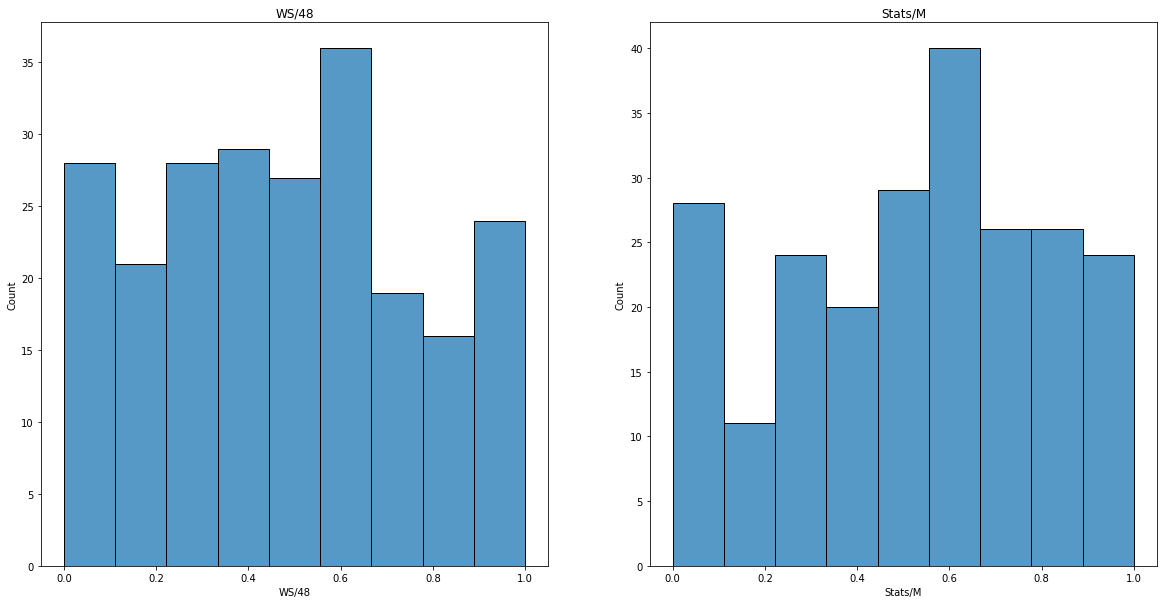

In [120]:
hist_maker(mvp_X_train)

In [127]:
mvp_pt = PowerTransformer().fit(mvp_X_train)

with open("../Transformers/mvp_pt.pkl", "wb") as file:
    pickle.dump(mvp_pt, file)

mvp_X_train_pt = mvp_pt.transform(mvp_X_train)
mvp_X_train_pt = pd.DataFrame(mvp_X_train_pt, columns = mvp_X_train.columns, index = mvp_X_train.index)

mvp_X_test_pt = mvp_pt.transform(mvp_X_test)
mvp_X_test_pt = pd.DataFrame(mvp_X_test_pt, columns = mvp_X_test.columns, index = mvp_X_test.index)

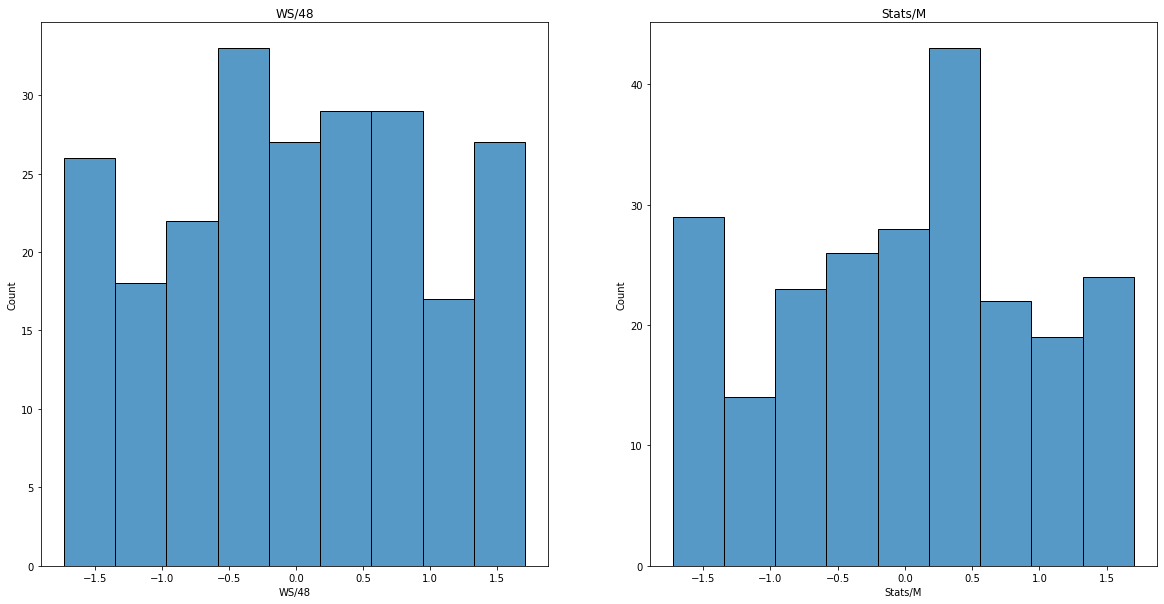

In [122]:
hist_maker(mvp_X_train_pt)

In [128]:
mvp_lr = LinearRegression().fit(mvp_X_train_pt, mvp_y_train)

with open("../Models/mvp_lr.pkl", "wb") as file:
    pickle.dump(mvp_lr, file)

mvp_y_train_pred = mvp_lr.predict(mvp_X_train_pt)
mvp_y_test_pred = mvp_lr.predict(mvp_X_test_pt)

print(round(r2_score(mvp_y_train, mvp_y_train_pred),2))
print(round(r2_score(mvp_y_test, mvp_y_test_pred),2))

0.38
0.29


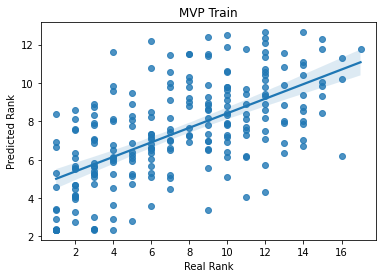

In [124]:
sns.regplot(x = mvp_y_train, y = mvp_y_train_pred).set(title="MVP Train")
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/MVPTrain.png")

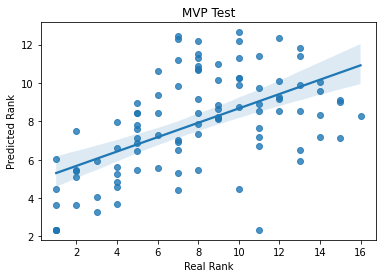

In [125]:
sns.regplot(x = mvp_y_test, y = mvp_y_test_pred).set(title="MVP Test")
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/MVPTest.png")